TDA TRADING STRATEGY - PHASE 2: GRAPH LAPLACIAN

⚠️  Downloading data (this only happens once per session)...
✅ Data downloaded and saved!

📂 Loading data...
✅ Loaded 1494 days × 20 stocks
Date range: 2019-01-03 to 2024-12-09

STEP 2: CORRELATION ANALYSIS

📊 Calculated 60-day correlation matrix
Average correlation: 0.152


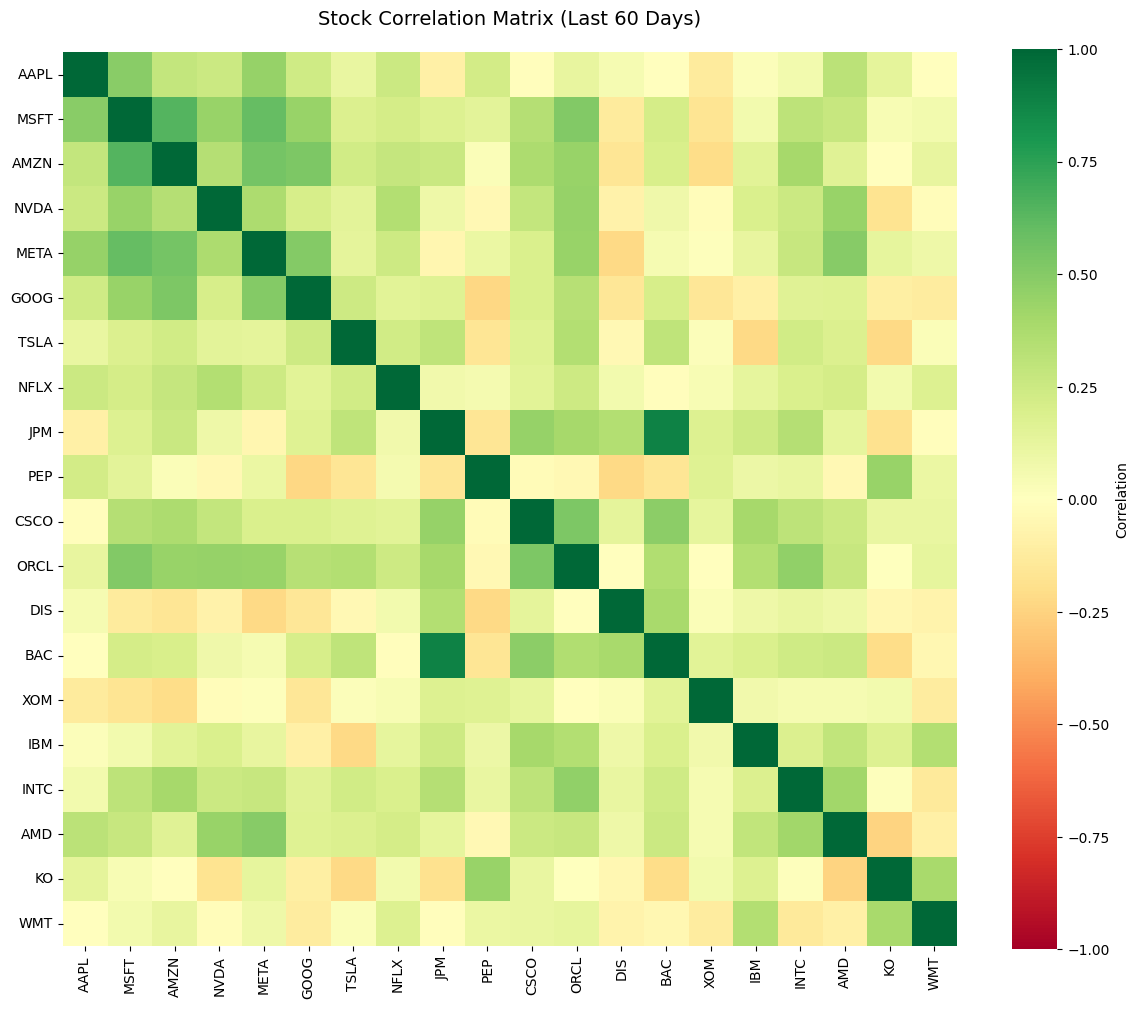

💾 Saved: correlation_matrix.png

STEP 3: GRAPH CONSTRUCTION

🔗 Graph with 20 nodes
Correlation threshold: 0.3
Number of edges: 43
Graph density: 22.63%

STEP 4: LAPLACIAN OPERATOR
✅ Created Laplacian matrices
Laplacian shape: (20, 20)
Row sums (should be ~0): [-0. -0. -0.]

STEP 5: DIFFUSION & RESIDUALS
⚙️  Parameters: α=0.5, T=3

📊 Results for 2024-12-09:

Top 5 positive residuals (potential LONG):
Stock    Actual  Smoothed  Residual
 AAPL  0.016101 -0.006490  0.022591
 MSFT  0.005523 -0.009033  0.014556
  PEP  0.010647  0.000625  0.010022
 GOOG  0.004595 -0.004656  0.009251
 ORCL -0.006469 -0.015325  0.008856

Top 5 negative residuals (potential SHORT):
Stock    Actual  Smoothed  Residual
  DIS -0.018162 -0.009728 -0.008433
  WMT -0.019540 -0.010209 -0.009331
 NFLX -0.022520 -0.010367 -0.012153
  IBM -0.033776 -0.013803 -0.019973
  AMD -0.055704 -0.015804 -0.039900

STEP 6: HISTORICAL RESIDUALS
⏳ Calculating residuals for 1434 days...
This takes ~1-2 minutes...
  Progress: 100/1494
 

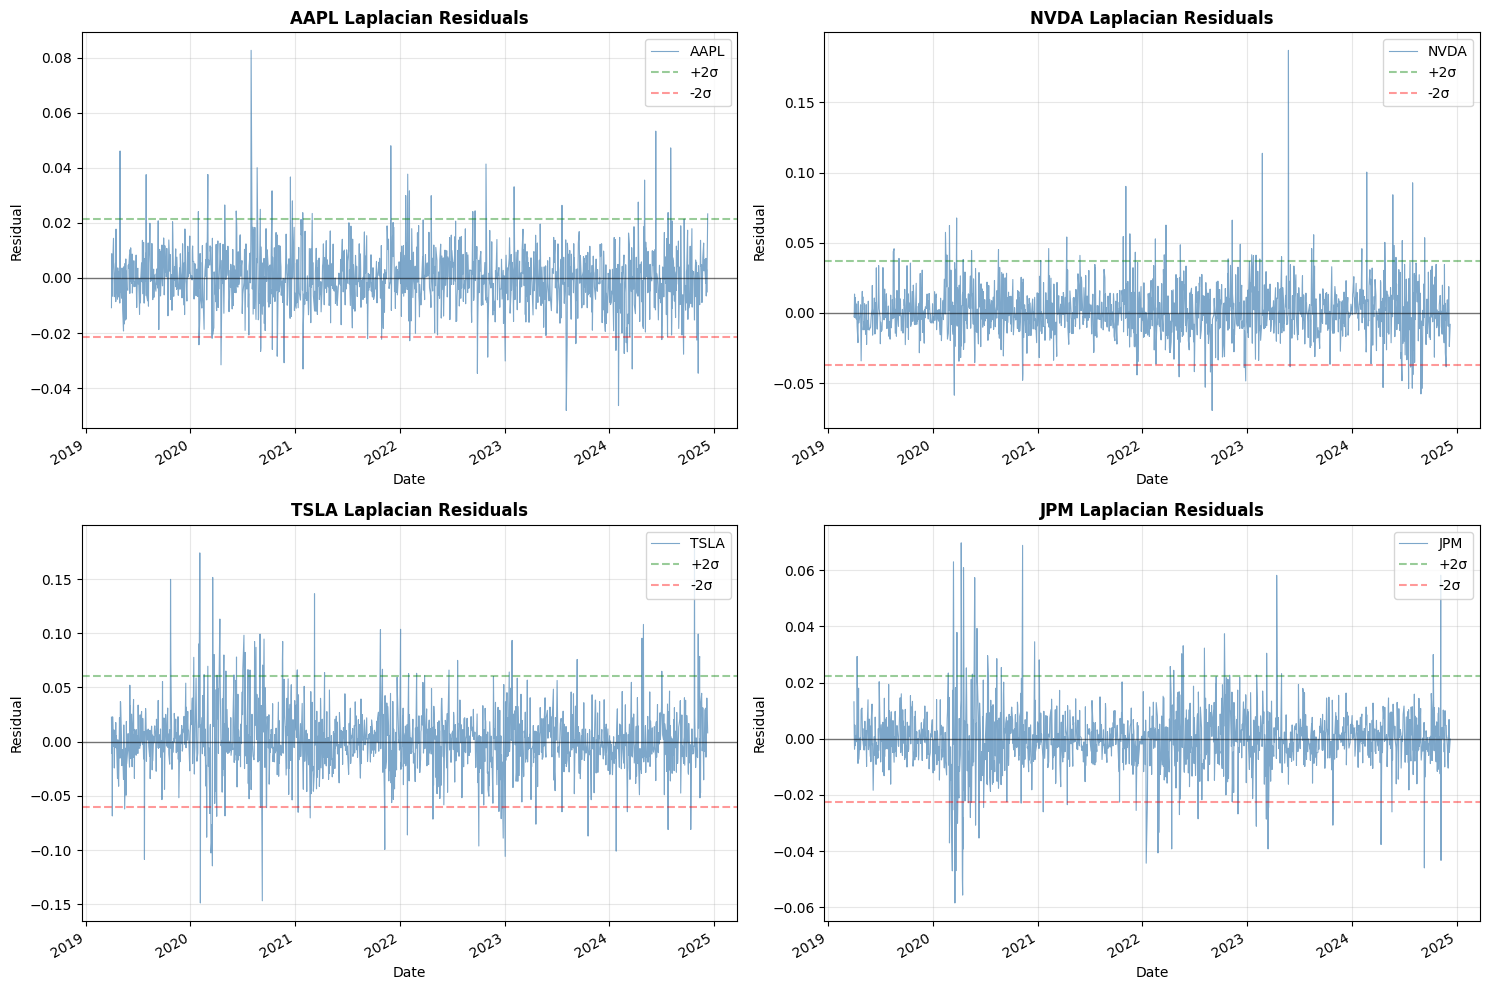

💾 Saved: residuals_over_time.png

📊 Residual Statistics:
Mean residual std: 0.0141

Most volatile:
  TSLA: 0.0303
  AMD: 0.0201
  NFLX: 0.0196

Least volatile:
  PEP: 0.0087
  KO: 0.0091
  MSFT: 0.0093

✅ PHASE 2 COMPLETE!

Created:
  ✅ Rolling correlation matrices
  ✅ Weighted graph (correlation-based)
  ✅ Graph Laplacian operator
  ✅ Diffusion formula: h = (I - αL)^T x
  ✅ Residuals: e = x - h
  ✅ Historical residuals (2019-2024)

Files:
  📊 correlation_matrix.png
  📊 residuals_over_time.png
  💾 laplacian_residuals.csv

🎯 Next: Phase 3 - Persistent Homology (Betti curves)

BONUS: RESIDUAL VOLATILITY REGIME ANALYSIS


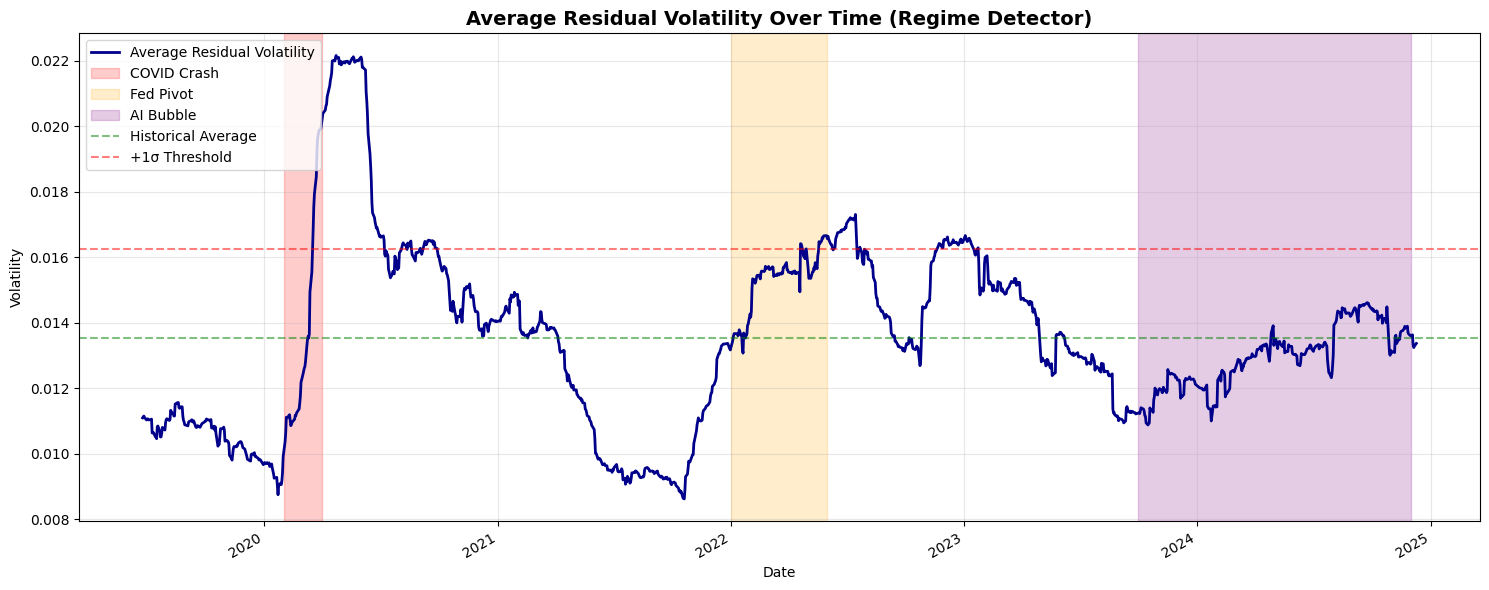

💾 Saved: residual_volatility_regimes.png

This shows when the graph structure was stable vs unstable
High volatility = unstable correlations = don't trade
Low volatility = stable correlations = safe to trade residuals


In [1]:
# ============================================================================
# TDA TRADING STRATEGY - PHASE 2: GRAPH LAPLACIAN
# ============================================================================

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import linalg
import warnings
warnings.filterwarnings('ignore')

print("=" * 70)
print("TDA TRADING STRATEGY - PHASE 2: GRAPH LAPLACIAN")
print("=" * 70)

# ============================================================================
# DATA SETUP (Auto-downloads if files don't exist)
# ============================================================================

if not os.path.exists('stock_returns.csv'):
    print("\n⚠️  Downloading data (this only happens once per session)...")

    import subprocess
    subprocess.run(['pip', 'install', 'yfinance', '-q'])
    import yfinance as yf

    universe = [
        'AAPL', 'MSFT', 'AMZN', 'NVDA', 'META', 'GOOG', 'TSLA',
        'NFLX', 'JPM', 'PEP', 'CSCO', 'ORCL', 'DIS', 'BAC',
        'XOM', 'IBM', 'INTC', 'AMD', 'KO', 'WMT'
    ]

    start_date = '2019-01-01'
    end_date = '2024-12-10'

    prices_dict = {}
    for ticker in universe:
        try:
            stock = yf.Ticker(ticker)
            hist = stock.history(start=start_date, end=end_date)
            if not hist.empty and 'Close' in hist.columns:
                prices_dict[ticker] = hist['Close']
        except:
            pass

    prices = pd.DataFrame(prices_dict)
    prices = prices.fillna(method='ffill').fillna(method='bfill')
    returns = prices.pct_change().dropna()

    prices.to_csv('stock_prices.csv')
    returns.to_csv('stock_returns.csv')
    print("✅ Data downloaded and saved!")
else:
    print("\n✅ Data files found in session!")

# ============================================================================
# STEP 1: LOAD DATA
# ============================================================================

print("\n📂 Loading data...")
returns = pd.read_csv('stock_returns.csv', index_col=0, parse_dates=True)
print(f"✅ Loaded {len(returns)} days × {len(returns.columns)} stocks")
print(f"Date range: {returns.index[0].date()} to {returns.index[-1].date()}")

# ============================================================================
# STEP 2: ROLLING CORRELATION MATRIX
# ============================================================================

print("\n" + "=" * 70)
print("STEP 2: CORRELATION ANALYSIS")
print("=" * 70)

LOOKBACK_WINDOW = 60  # 60 days ≈ 3 months

recent_returns = returns.tail(LOOKBACK_WINDOW)
corr_matrix = recent_returns.corr()

print(f"\n📊 Calculated {LOOKBACK_WINDOW}-day correlation matrix")
print(f"Average correlation: {corr_matrix.values[np.triu_indices_from(corr_matrix.values, k=1)].mean():.3f}")

# Visualize
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='RdYlGn', center=0,
            vmin=-1, vmax=1, square=True, cbar_kws={'label': 'Correlation'})
plt.title(f'Stock Correlation Matrix (Last {LOOKBACK_WINDOW} Days)', fontsize=14, pad=20)
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=150, bbox_inches='tight')
plt.show()
print("💾 Saved: correlation_matrix.png")

# ============================================================================
# STEP 3: BUILD WEIGHTED GRAPH
# ============================================================================

print("\n" + "=" * 70)
print("STEP 3: GRAPH CONSTRUCTION")
print("=" * 70)

# Adjacency matrix from absolute correlations
adjacency_matrix = corr_matrix.abs().values.copy()
np.fill_diagonal(adjacency_matrix, 0)

# Threshold weak connections
CORRELATION_THRESHOLD = 0.3
adjacency_matrix[adjacency_matrix < CORRELATION_THRESHOLD] = 0

n_edges = (adjacency_matrix > 0).sum() / 2
print(f"\n🔗 Graph with {len(returns.columns)} nodes")
print(f"Correlation threshold: {CORRELATION_THRESHOLD}")
print(f"Number of edges: {n_edges:.0f}")
print(f"Graph density: {n_edges / (len(returns.columns) * (len(returns.columns)-1) / 2):.2%}")

# ============================================================================
# STEP 4: GRAPH LAPLACIAN
# ============================================================================

print("\n" + "=" * 70)
print("STEP 4: LAPLACIAN OPERATOR")
print("=" * 70)

# Degree matrix
degree_vector = adjacency_matrix.sum(axis=1)
degree_matrix = np.diag(degree_vector)

# Standard Laplacian: L = D - W
laplacian = degree_matrix - adjacency_matrix

# Normalized Laplacian: L_norm = I - D^(-1/2) W D^(-1/2)
degree_sqrt_inv = np.diag(1.0 / np.sqrt(degree_vector + 1e-8))
identity = np.eye(len(degree_vector))
normalized_laplacian = identity - degree_sqrt_inv @ adjacency_matrix @ degree_sqrt_inv

print(f"✅ Created Laplacian matrices")
print(f"Laplacian shape: {laplacian.shape}")
print(f"Row sums (should be ~0): {laplacian.sum(axis=1)[:3].round(6)}")

# ============================================================================
# STEP 5: LAPLACIAN DIFFUSION
# ============================================================================

print("\n" + "=" * 70)
print("STEP 5: DIFFUSION & RESIDUALS")
print("=" * 70)

ALPHA = 0.5  # Diffusion strength
T = 3        # Iterations

print(f"⚙️  Parameters: α={ALPHA}, T={T}")

# Diffusion operator: (I - αL)^T
diffusion_operator = linalg.fractional_matrix_power(identity - ALPHA * normalized_laplacian, T)

# Test on most recent day
recent_day_returns = returns.iloc[-1].values
smoothed_returns = diffusion_operator @ recent_day_returns
residuals = recent_day_returns - smoothed_returns

# Display results
residual_df = pd.DataFrame({
    'Stock': returns.columns,
    'Actual': recent_day_returns,
    'Smoothed': smoothed_returns,
    'Residual': residuals
}).sort_values('Residual', ascending=False)

print(f"\n📊 Results for {returns.index[-1].date()}:")
print("\nTop 5 positive residuals (potential LONG):")
print(residual_df.head().to_string(index=False))
print("\nTop 5 negative residuals (potential SHORT):")
print(residual_df.tail().to_string(index=False))

# ============================================================================
# STEP 6: CALCULATE HISTORICAL RESIDUALS
# ============================================================================

print("\n" + "=" * 70)
print("STEP 6: HISTORICAL RESIDUALS")
print("=" * 70)

print(f"⏳ Calculating residuals for {len(returns) - LOOKBACK_WINDOW} days...")
print("This takes ~1-2 minutes...")

def calculate_residuals_rolling(returns_df, window=60, alpha=0.5, T=3, threshold=0.3):
    residuals_list = []
    dates = []

    for i in range(window, len(returns_df)):
        if i % 100 == 0:
            print(f"  Progress: {i}/{len(returns_df)}")

        # Rolling window correlation
        returns_window = returns_df.iloc[i-window:i]
        corr = returns_window.corr()

        # Build graph
        adj = corr.abs().values.copy()
        np.fill_diagonal(adj, 0)
        adj[adj < threshold] = 0

        # Normalized Laplacian
        deg = adj.sum(axis=1)
        deg_sqrt_inv = np.diag(1.0 / np.sqrt(deg + 1e-8))
        I = np.eye(len(deg))
        L_norm = I - deg_sqrt_inv @ adj @ deg_sqrt_inv

        # Diffusion
        diff_op = linalg.fractional_matrix_power(I - alpha * L_norm, T)

        # Residuals
        x = returns_df.iloc[i].values
        h = diff_op @ x
        e = x - h

        residuals_list.append(e)
        dates.append(returns_df.index[i])

    return pd.DataFrame(residuals_list, index=dates, columns=returns_df.columns)

residuals_ts = calculate_residuals_rolling(returns, window=LOOKBACK_WINDOW,
                                           alpha=ALPHA, T=T,
                                           threshold=CORRELATION_THRESHOLD)

print(f"\n✅ Calculated {len(residuals_ts)} days of residuals")
print(f"Date range: {residuals_ts.index[0].date()} to {residuals_ts.index[-1].date()}")

# Save
residuals_ts.to_csv('laplacian_residuals.csv')
print("💾 Saved: laplacian_residuals.csv")

# ============================================================================
# STEP 7: VISUALIZE RESIDUALS
# ============================================================================

print("\n" + "=" * 70)
print("STEP 7: RESIDUAL VISUALIZATION")
print("=" * 70)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
stocks_to_plot = ['AAPL', 'NVDA', 'TSLA', 'JPM']

for idx, stock in enumerate(stocks_to_plot):
    ax = axes[idx // 2, idx % 2]
    residuals_ts[stock].plot(ax=ax, linewidth=0.8, alpha=0.7, color='steelblue')
    ax.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.5)

    std = residuals_ts[stock].std()
    ax.axhline(y=2*std, color='green', linestyle='--', alpha=0.4, label='+2σ')
    ax.axhline(y=-2*std, color='red', linestyle='--', alpha=0.4, label='-2σ')

    ax.set_title(f'{stock} Laplacian Residuals', fontsize=12, fontweight='bold')
    ax.set_xlabel('Date')
    ax.set_ylabel('Residual')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('residuals_over_time.png', dpi=150, bbox_inches='tight')
plt.show()
print("💾 Saved: residuals_over_time.png")

# Statistics
print(f"\n📊 Residual Statistics:")
print(f"Mean residual std: {residuals_ts.std().mean():.4f}")
print(f"\nMost volatile:")
for stock, vol in residuals_ts.std().nlargest(3).items():
    print(f"  {stock}: {vol:.4f}")
print(f"\nLeast volatile:")
for stock, vol in residuals_ts.std().nsmallest(3).items():
    print(f"  {stock}: {vol:.4f}")

print("\n" + "=" * 70)
print("✅ PHASE 2 COMPLETE!")
print("=" * 70)
print("\nCreated:")
print("  ✅ Rolling correlation matrices")
print("  ✅ Weighted graph (correlation-based)")
print("  ✅ Graph Laplacian operator")
print("  ✅ Diffusion formula: h = (I - αL)^T x")
print("  ✅ Residuals: e = x - h")
print("  ✅ Historical residuals (2019-2024)")
print("\nFiles:")
print("  📊 correlation_matrix.png")
print("  📊 residuals_over_time.png")
print("  💾 laplacian_residuals.csv")
print("\n🎯 Next: Phase 3 - Persistent Homology (Betti curves)")
print("=" * 70)
print("\n" + "=" * 70)
print("BONUS: RESIDUAL VOLATILITY REGIME ANALYSIS")
print("=" * 70)

# Calculate rolling volatility of residuals
rolling_window = 60
residual_vol = residuals_ts.rolling(window=rolling_window).std()

# Plot average residual volatility over time
plt.figure(figsize=(15, 6))
avg_vol = residual_vol.mean(axis=1)
avg_vol.plot(linewidth=2, color='darkblue', label='Average Residual Volatility')

# Mark crisis periods
crisis_periods = [
    ('2020-02-01', '2020-04-01', 'COVID Crash', 'red'),
    ('2022-01-01', '2022-06-01', 'Fed Pivot', 'orange'),
    ('2023-10-01', '2024-12-01', 'AI Bubble', 'purple')
]

for start, end, label, color in crisis_periods:
    plt.axvspan(pd.to_datetime(start), pd.to_datetime(end),
                alpha=0.2, color=color, label=label)

plt.axhline(y=avg_vol.mean(), color='green', linestyle='--',
            alpha=0.5, label='Historical Average')
plt.axhline(y=avg_vol.mean() + avg_vol.std(), color='red',
            linestyle='--', alpha=0.5, label='+1σ Threshold')

plt.title('Average Residual Volatility Over Time (Regime Detector)',
          fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('residual_volatility_regimes.png', dpi=150, bbox_inches='tight')
plt.show()

print("💾 Saved: residual_volatility_regimes.png")
print("\nThis shows when the graph structure was stable vs unstable")
print("High volatility = unstable correlations = don't trade")
print("Low volatility = stable correlations = safe to trade residuals")